# 감성분석 결과와 주가 데이터 비교

## 감성분석 결과 데이터프레임

In [1]:
import koreanize_matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

months = ['1월', '2월', '3월', '4월', '5월', '6월',
           '7월', '8월', '9월', '10월', '11월', '12월']
company = "현대차"

sentiment_result = pd.read_csv("../data/project/predicted_현대차_2023.csv") # 감성분석 결과 csv파일 읽어오기
sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result['month'] = sentiment_result['date'].dt.month

# 감성분석 데이터프레임
sentiments_data = []

for index, row in sentiment_result.iterrows():
    month = row['month']
    prediction = row['prediction']
    score = row['score']
    sentiments_data.append([month, company, prediction, score])

sentiments_df = pd.DataFrame(sentiments_data, columns=['month', 'company', 'prediction', 'score'])
sentiments_df

,month,company,prediction,score
0,1,현대차,악재,5.234759
1,1,현대차,중립,5.075768
2,1,현대차,호재,4.679605
3,1,현대차,악재,6.213379
4,1,현대차,호재,6.677591
...,...,...,...,...
3300,12,현대차,호재,5.704594
3301,12,현대차,호재,6.631795
3302,12,현대차,중립,3.217138
3303,12,현대차,호재,6.663548


In [2]:
# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df['total'] = sentiments_df['prediction'].map(weights) * sentiments_df['score']
sentiments_df['month'] = sentiments_df['month'].astype(str) + '월'

df_monthly_total = sentiments_df.groupby(['month', 'company'])['total'].sum().unstack()
df_monthly_total = df_monthly_total.reindex(months)

df_monthly_total

company,현대차
month,
1월,491.696390
2월,516.442365
3월,505.433772
4월,635.747800
5월,522.762326
6월,651.297531
7월,531.887810
8월,414.675050
9월,490.673383


In [3]:
sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       3305 non-null   object 
 1   company     3305 non-null   object 
 2   prediction  3305 non-null   object 
 3   score       3305 non-null   float64
 4   total       3305 non-null   float64
dtypes: float64(2), object(3)
memory usage: 129.2+ KB


In [4]:
import FinanceDataReader as fdr

df_krx = fdr.StockListing('KRX')
hyundai = df_krx[df_krx["Name"].isin(["현대차"])]
hyundai

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
6,005380,KR7005380001,현대차,KOSPI,,184800,1,4700,2.61,181200,184800,180900,374215,68742717200,39091022308800,211531506,STK


In [5]:
ds_stock = fdr.DataReader('005380', '2023-01-01', '2023-12-31')
ds_stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,154000,161000,154000,157000,1132256,0.039735
2023-01-03,158500,160500,156000,159000,787752,0.012739
2023-01-04,157500,161000,157500,160500,463444,0.009434
2023-01-05,161000,161500,158000,159000,577152,-0.009346
2023-01-06,157500,161500,157500,159500,502420,0.003145


## 감성분석 결과 시각화

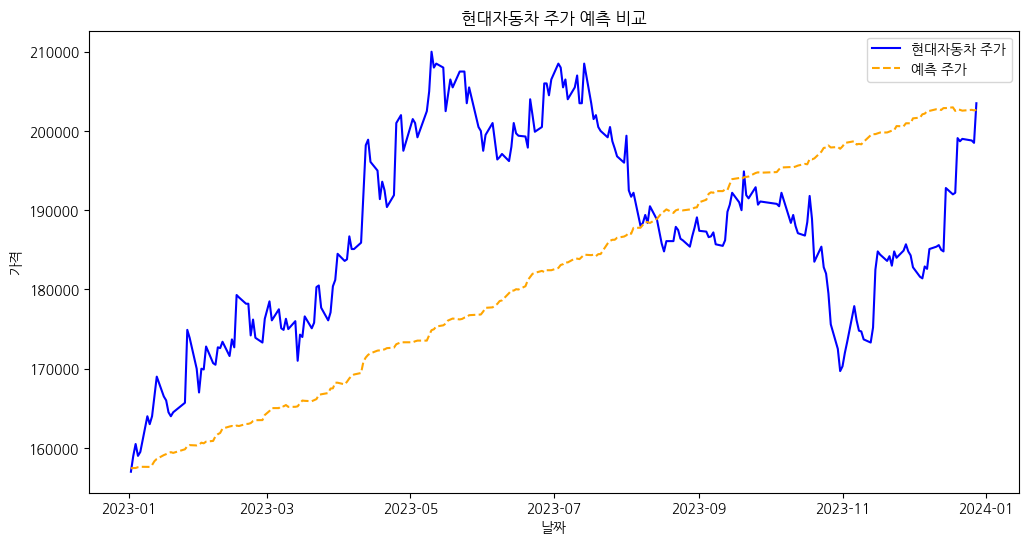

In [6]:
import random
import koreanize_matplotlib
from datetime import datetime, timedelta
import FinanceDataReader as fdr

company = "현대자동차"

sentiment_result = pd.read_csv("../data/project/predicted_현대차_2023.csv") # 감성분석 결과 csv파일 읽어오기

sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result["date"] = sentiment_result["date"].dt.date

sentiments_data = []

for index, row in sentiment_result.iterrows():
    date = row['date']
    prediction = row['prediction']
    score = row['score']
    sentiments_data.append([date, company, prediction, score])

sentiments_df2 = pd.DataFrame(sentiments_data, columns=['date', 'company', 'prediction', 'score'])

# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df2['total'] = sentiments_df2['prediction'].map(weights) * sentiments_df2['score']

df_hv = sentiments_df2.groupby(['date', 'company']).agg({'total': 'sum'}).reset_index()
df_hv['date'] = pd.to_datetime(df_hv['date'])
df_hv = df_hv.set_index('date')

# 주가 데이터에 감성분석 결과 총점 추가
hv_stock = fdr.DataReader('005380', '2023-01-01', '2023-12-31')
hv_stock['Sentiment_Total'] = df_hv['total']
hv_stock['Sentiment_Total'] = hv_stock['Sentiment_Total'].fillna(0)

# 감성분석 결과 Scaling
scaling_factor = 9.3
hv_stock['Sentiment_Total'] = hv_stock['Sentiment_Total'] * scaling_factor

# 누적 합 계산
hv_stock['Sentiment_Total_Cumulative'] = hv_stock['Sentiment_Total'].cumsum()

# 오프셋 설정
offset = 157000
hv_stock['Sentiment_Total_Cumulative_Offset'] = hv_stock['Sentiment_Total_Cumulative'] + offset

plt.figure(figsize=(12, 6))
plt.plot(hv_stock['Close'], label='현대자동차 주가', color='blue')
plt.plot(hv_stock['Sentiment_Total_Cumulative_Offset'], label='예측 주가', linestyle='--', color='orange')
plt.title('현대자동차 주가 예측 비교')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.show()

In [7]:
hv_stock

,Open,High,Low,Close,Volume,Change,Sentiment_Total,Sentiment_Total_Cumulative,Sentiment_Total_Cumulative_Offset
Date,,,,,,,,,
2023-01-02,154000,161000,154000,157000,1132256,0.039735,440.499356,440.499356,157440.499356
2023-01-03,158500,160500,156000,159000,787752,0.012739,23.560603,464.059959,157464.059959
2023-01-04,157500,161000,157500,160500,463444,0.009434,4.262972,468.322930,157468.322930
2023-01-05,161000,161500,158000,159000,577152,-0.009346,105.312657,573.635587,157573.635587
2023-01-06,157500,161500,157500,159500,502420,0.003145,49.002618,622.638206,157622.638206
...,...,...,...,...,...,...,...,...,...
2023-12-21,197500,202000,197100,198700,545031,-0.002009,-45.053935,45668.077045,202668.077045
2023-12-22,200000,200500,198500,199000,347866,0.001510,-103.781134,45564.295911,202564.295911
2023-12-26,200500,200500,197700,198800,409928,-0.001005,102.181362,45666.477273,202666.477273


### 감성분석 결과 기반 경향선과 주가 데이터 최적경향선 비교

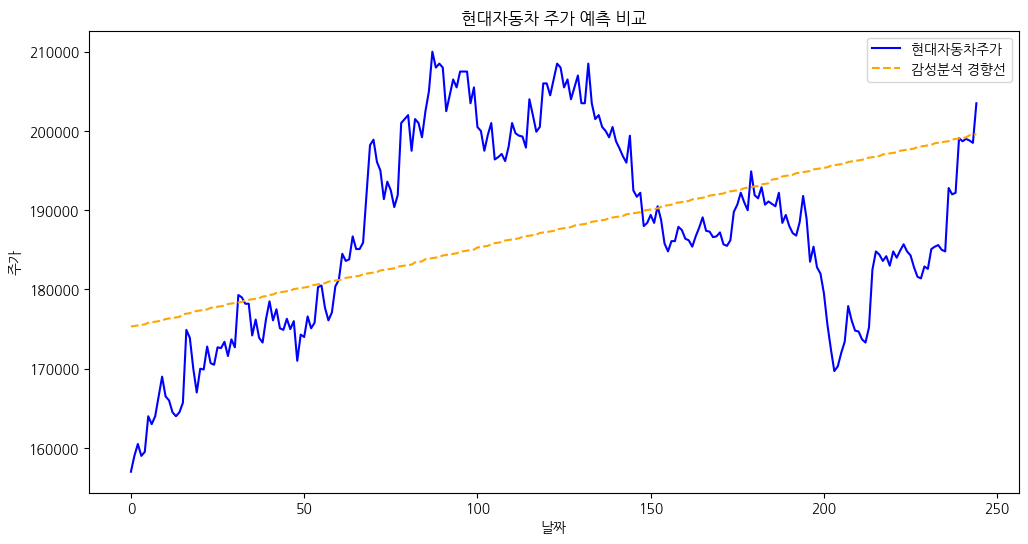

In [8]:
import FinanceDataReader as fdr
import seaborn as sns
import matplotlib.pyplot as plt

hv_stock = fdr.DataReader('005380', '2023-01-01', '2023-12-31')

# 감성분석 결과의 크기 Scaling
scaling_factor = 5
df_hv['Sentiment_Total'] = df_hv['total'] * scaling_factor

hv_stock = hv_stock.sort_index()
df_hv = df_hv.sort_index()

# 날짜를 일로 나타내는 정수로 변환
hv_stock['Date_Integer'] = (hv_stock.index - hv_stock.index.min()).days
df_hv['Date_Integer'] = (df_hv.index - df_hv.index.min()).days

# 주식 데이터와 감성분석 결과 날짜기준 병합
merged_data = pd.merge(hv_stock, df_hv, left_on='Date_Integer', right_on='Date_Integer', how='left')

# 결측치 처리
merged_data['Sentiment_Total'] = merged_data['Sentiment_Total'].fillna(0)

# 감성분석 결과기반 1차 함수의 계수 및 y값 계산
coeff = np.polyfit(merged_data['Date_Integer'], merged_data['Sentiment_Total'].cumsum(), 1)
merged_data['Sentiment_Linear'] = np.polyval(coeff, merged_data['Date_Integer'])

# 오프셋 설정
offset = merged_data['Close'].mean() - merged_data['Sentiment_Linear'].iloc[len(merged_data) // 2]
merged_data['Sentiment_Linear_Offset'] = merged_data['Sentiment_Linear'] + offset

plt.figure(figsize=(12, 6))
plt.plot(merged_data['Close'], label='현대자동차주가', color='blue')
plt.plot(merged_data['Sentiment_Linear_Offset'], label='감성분석 경향선', linestyle='--', color='orange')
plt.title('현대자동차 주가 예측 비교')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.show()


In [9]:
import pandas as pd
import cufflinks as cf
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
cf.set_config_file(theme='pearl', world_readable=False)
cf.go_offline()
single_stock = fdr.DataReader('005380', '2023-01-01', '2023-12-31')
single_stock['Close'].iplot(title='현대자동차 최적경향선', bestfit=True, bestfit_colors=['blue']) # 수익률 시각화, bestfit:최적 경향선 추가(추세 파악 용이)

# 상관분석

In [10]:
hv_stock.index = pd.to_datetime(hv_stock.index)

# 월별 평균 수익률 계산
monthly_avg_returns = hv_stock['Close'].resample('M').mean().pct_change()

print(monthly_avg_returns)

Date
2023-01-31         NaN
2023-02-28    0.054782
2023-03-31    0.017475
2023-04-30    0.088220
2023-05-31    0.062923
2023-06-30   -0.021011
2023-07-31    0.011380
2023-08-31   -0.069649
2023-09-30    0.004461
2023-10-31   -0.023866
2023-11-30   -0.028452
2023-12-31    0.058113
Freq: M, Name: Close, dtype: float64


In [11]:
hv_stock

,Open,High,Low,Close,Volume,Change,Date_Integer
Date,,,,,,,
2023-01-02,154000,161000,154000,157000,1132256,0.039735,0
2023-01-03,158500,160500,156000,159000,787752,0.012739,1
2023-01-04,157500,161000,157500,160500,463444,0.009434,2
2023-01-05,161000,161500,158000,159000,577152,-0.009346,3
2023-01-06,157500,161500,157500,159500,502420,0.003145,4
...,...,...,...,...,...,...,...
2023-12-21,197500,202000,197100,198700,545031,-0.002009,353
2023-12-22,200000,200500,198500,199000,347866,0.001510,354
2023-12-26,200500,200500,197700,198800,409928,-0.001005,358


In [12]:
company = "현대자동차"

sentiment_result = pd.read_csv("../data/project/predicted_현대차_2023.csv") # 감성분석 결과 csv파일 읽어오기
sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result['month'] = sentiment_result['date'].dt.month

sentiments_data = []

for index, row in sentiment_result.iterrows():
    
    month = row['month']
    prediction = row['prediction']
    score = row['score']
   
    sentiments_data.append([month, company, prediction, score])

sentiments_df = pd.DataFrame(sentiments_data, columns=['month', 'company', 'prediction', 'score'])

# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df['total'] = sentiments_df['prediction'].map(weights) * sentiments_df['score']
sentiments_df = sentiments_df.drop('company', axis=1)
sentiments_df = sentiments_df.rename(columns={'현대자동차': 'total'})
sentiments_df['month'] = sentiments_df['month'].astype(str) + '월'

# 'month' 기준 그룹화 및 합계
df_monthly_total = sentiments_df.groupby('month')['total'].sum().reset_index()

df_monthly_total['month'] = pd.Categorical(df_monthly_total['month'], categories=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'], ordered=True)
df_monthly_total = df_monthly_total.sort_values('month')
df_monthly_total = df_monthly_total.reset_index(drop=True)

# 월별 감성분석 변동
monthly_avg_total = df_monthly_total['total']
monthly_avg_total_diff = monthly_avg_total.pct_change()

print(monthly_avg_total_diff)


0          NaN
1     0.050328
2    -0.021316
3     0.257826
4    -0.177721
5     0.245877
6    -0.183341
7    -0.220371
8     0.183272
9    -0.419142
10    0.393134
11   -0.215581
Name: total, dtype: float64


In [13]:
sentiment_predicted_diff = monthly_avg_total_diff.tolist()
month_avg_gain = monthly_avg_returns.tolist()

if pd.isna(month_avg_gain[0]):
    month_avg_gain = month_avg_gain[1:]
    sentiment_predicted_diff = sentiment_predicted_diff[1:]


In [14]:
import numpy as np
import scipy.stats

# 두 리스트 간의 상관 계수 계산
correlation_coefficient, p_value = scipy.stats.pearsonr(sentiment_predicted_diff, month_avg_gain)

print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Statistically significant correlation.")
else:
    print("No statistically significant correlation.")

Correlation Coefficient: 0.08677877890872379
P-value: 0.7997258735438108
No statistically significant correlation.


In [15]:
import pandas as pd

correlation_data = pd.DataFrame({'월별 평균 수익률 변동': month_avg_gain, '월별 감성분석 변동': sentiment_predicted_diff})

# 상관 행렬
correlation_matrix = correlation_data.corr()

print(correlation_matrix)

              월별 평균 수익률 변동  월별 감성분석 변동
월별 평균 수익률 변동      1.000000    0.086779
월별 감성분석 변동        0.086779    1.000000


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에 인덱스 설정
index_months = [str(i) + '월' for i in range(2, 13)]
correlation_data.index = index_months

correlation_data


,월별 평균 수익률 변동,월별 감성분석 변동
2월,0.054782,0.050328
3월,0.017475,-0.021316
4월,0.088220,0.257826
5월,0.062923,-0.177721
6월,-0.021011,0.245877
7월,0.011380,-0.183341
8월,-0.069649,-0.220371
9월,0.004461,0.183272
10월,-0.023866,-0.419142
11월,-0.028452,0.393134


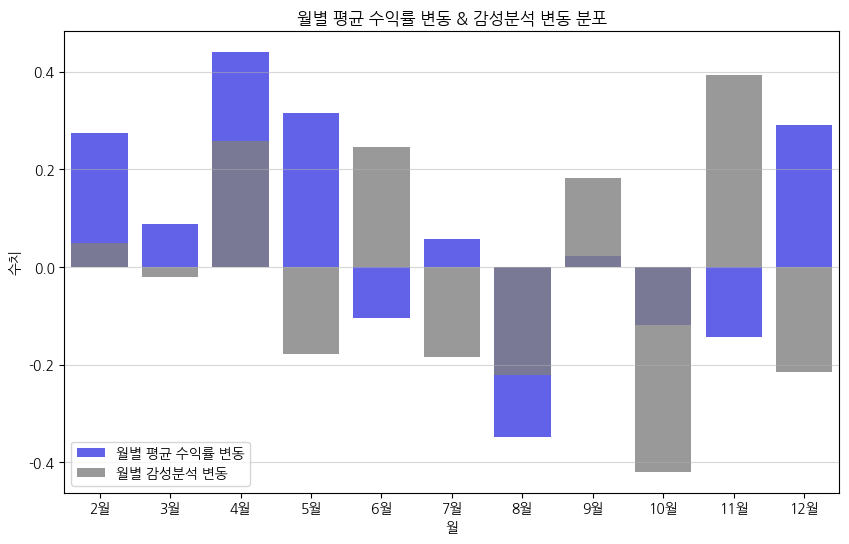

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 월별 평균 수익률 변동에 적절한 가중치 설정
correlation_data['월별 평균 수익률 변동'] = correlation_data['월별 평균 수익률 변동'] * 5

# 히스토그램
plt.figure(figsize=(10, 6))
plt.grid(axis='y', which='major', alpha=0.5)
sns.barplot(x=index_months, y='월별 평균 수익률 변동', data=correlation_data, alpha=0.7, label='월별 평균 수익률 변동', color='Blue')
sns.barplot(x=index_months, y='월별 감성분석 변동', data=correlation_data, alpha=0.8, label='월별 감성분석 변동', color = 'Gray')
plt.title('월별 평균 수익률 변동 & 감성분석 변동 분포')
plt.xlabel('월')
plt.ylabel('수치')
plt.legend()
plt.show()